In [5]:
import importlib
import src.utils
import src.models

importlib.reload(src.utils)
importlib.reload(src.models)

from src.utils import load_data, load_model, DatasetMetadata
import torch
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sympy as sp
# str to sympy
from sympy.parsing.sympy_parser import (parse_expr, standard_transformations, implicit_multiplication_application)

from torch.utils.data import DataLoader
from src.models import LogisticModel
import warnings
warnings.filterwarnings("ignore")

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [6]:
def distance(original, new, weights):
    return ((original - new) ** 2 * weights).sum()

In [7]:
def unscale_instance(instance: torch.Tensor, metadata: DatasetMetadata, inplace: bool = False):
    unscaled_cols = metadata.scaler.inverse_transform(instance[metadata.cols_for_scaler].detach().cpu().numpy().reshape(1, -1))
    if inplace:
        instance[metadata.cols_for_scaler] = torch.tensor(unscaled_cols, dtype=torch.float32).to(device)
        return instance
    else:
        instance_clone = instance.clone()
        instance_clone[metadata.cols_for_scaler] = torch.tensor(unscaled_cols, dtype=torch.float32).to(device)
        return instance_clone
    
def scale_instance(instance: torch.Tensor, metadata: DatasetMetadata, inplace: bool = False):
    unscaled_cols = metadata.scaler.transform(instance[metadata.cols_for_scaler].detach().cpu().numpy().reshape(1, -1))
    if inplace:
        instance[metadata.cols_for_scaler] = torch.tensor(unscaled_cols, dtype=torch.float32).to(device)
        return instance
    else:
        instance_clone = instance.clone()
        instance_clone[metadata.cols_for_scaler] = torch.tensor(unscaled_cols, dtype=torch.float32).to(device)
        return instance_clone

In [8]:
filename = 'data/Loan_default.csv'
model_name = "model_small"
model_dict = "models/"+model_name+".pth"

In [9]:
# load the model
test_data: DataLoader
_, _, test_data, _, metadata = load_data(filename, batch_size=1024)

inputs = next(iter(test_data))[0]

# define model
model = load_model(model_name).to(device)

torch.save(model.state_dict(), model_dict)


## Extract model equation

In [10]:
import sympy as sp
import torch

def extract_symbolic_equation(model: torch.nn.Module, instance: torch.Tensor):
    """
    Extracts a symbolic equation from a trained PyTorch model.
    Assumes a feedforward structure with linear layers and activations.
    """
    # Define symbolic variables for input features
    x2, x3 = sp.symbols('x2 x3')  # Inputs
    # constants = sp.symbols(f'c1:{model.input_dim + 1}')  # Constants for other features
    
    # Build input vector with constants
    x = [instance[i].item() if i not in [1, 2] else (x2 if i == 1 else x3) for i in range(model.input_dim)]
    
    # Convert to a sympy matrix
    X = sp.Matrix(x)
    activations = []

    # Iterate over layers
    for layer in model.layers:
        if isinstance(layer, torch.nn.Linear):
            W = sp.Matrix(layer.weight.detach().numpy())  # Extract weight matrix
            b = sp.Matrix(layer.bias.detach().numpy())    # Extract bias
            X = W * X + b  # Apply linear transformation
        elif isinstance(layer, torch.nn.ReLU):
            activations.append(X)
            X = X.applyfunc(lambda val: sp.Max(0, val))  # ReLU activation
        elif isinstance(layer, torch.nn.Sigmoid):
            activations.append(X)
            X = X.applyfunc(lambda val: 1 / (1 + sp.exp(-val)))  # Sigmoid activation
        # X.subs({sp.symbols(f'c{i+1}'): val for i, val in enumerate(inputs[0]) if i != 1 and i != 2})
        print("Done: ", layer)
        # print(X)


    # Apply softmax at the end
    denominator = sp.Add(*(sp.exp(e) for e in X))
    softmax_expr = sp.Matrix([sp.exp(e) / denominator for e in X])

    return softmax_expr, activations # .simplify()

# Example usage
model_sym = LogisticModel(inputs.shape[1], hidden_sizes=[16, 8])
model_sym.load_state_dict(torch.load(model_dict))  # Load trained weights
symbolic_eq, activations = extract_symbolic_equation(model_sym, inputs[0])
model_eq = symbolic_eq[0]
print(symbolic_eq)


Done:  Linear(in_features=24, out_features=16, bias=True)
Done:  Sigmoid()
Done:  Linear(in_features=16, out_features=8, bias=True)
Done:  Sigmoid()
Done:  Linear(in_features=8, out_features=2, bias=True)
Done:  Softmax(dim=1)
Matrix([[1.14736*exp(0.592727/(1.25527*exp(0.60966/(0.18672023781861*exp(0.603065*x2 - 0.420633*x3) + 1) + 0.520607/(0.130793777772998*exp(0.506093*x2 - 0.43031*x3) + 1) + 0.515989/(0.159123828844163*exp(0.410075*x2 - 0.333227*x3) + 1) + 0.538932/(0.149384390603055*exp(0.367078*x2 - 0.39095*x3) + 1) - 0.382252/(4.74907893703268*exp(-0.332786*x2 + 0.335924*x3) + 1) - 0.416536/(7.08653417732447*exp(-0.395104*x2 + 0.519326*x3) + 1) - 0.123144/(5.28290240645382*exp(-0.395989*x2 + 0.341228*x3) + 1) - 0.28782/(7.54697936678862*exp(-0.400508*x2 + 0.289444*x3) + 1) - 0.257044/(7.1508297624139*exp(-0.420954*x2 + 0.472439*x3) + 1) - 0.473963/(4.62519776186675*exp(-0.424769*x2 + 0.478419*x3) + 1) - 0.301906/(4.52632472610194*exp(-0.476373*x2 + 0.434195*x3) + 1) - 0.2646/(7.

In [11]:
# with open('small.txt', 'w') as f:
#     f.write(str(symbolic_eq))
with open('small.txt', 'r') as f:
    symbolic_eq1 = f.read()
    symbolic_eq1 = parse_expr(symbolic_eq1)

## Training

In [12]:
person: torch.Tensor = inputs[0] # 4, 5
# metadata.cols_for_mask = [False] * len(metadata.cols_for_mask)
# metadata.cols_for_mask[1] = True
# metadata.cols_for_mask[2] = True
# metadata.cols_for_mask[3] = True
# metadata.cols_for_mask[4] = True
# metadata.cols_for_mask[5] = True



In [13]:
outputs = model(inputs).argmax(dim=1)
inputs_useful = inputs[outputs == 1]

In [14]:
weights = torch.tensor(metadata.cols_for_mask, dtype=torch.int).to(device)
print(person)
print(weights)

tensor([-1.7010e+00,  1.2312e+00,  5.0621e-01,  1.0682e+00, -1.5644e-02,
         1.3419e+00,  1.2804e+00, -1.5259e-03, -1.0836e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  1.0000e+00,  1.0000e+00,  1.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
       dtype=torch.float32)
tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       dtype=torch.int32)


In [15]:
def check_definite_positive_hessian(matrix: torch.Tensor):
    try:
        # Cholesky decomposition only works for positive definite matrices
        torch.linalg.cholesky(matrix)
        return True
    except RuntimeError:
        return False
    
def get_eigenvalues(matrix: torch.Tensor) -> torch.Tensor:
    """
    Get the eigenvalues of a given matrix.

    Args:
        matrix (torch.Tensor): The input square matrix.

    Returns:
        torch.Tensor: Eigenvalues of the matrix.
    """
    if matrix.size(0) != matrix.size(1):
        raise ValueError("Matrix must be square.")

    return torch.linalg.eigvals(matrix).real

In [16]:
def ldl_decomposition(A):
    n = A.shape[0]
    L = torch.eye(n)
    D = torch.zeros(n, n)

    for i in range(n):
        D[i, i] = A[i, i] - torch.sum(L[i, :i]**2 * torch.diag(D)[:i])

        for j in range(i+1, n):
            L[j, i] = (A[j, i] - torch.sum(L[j, :i] * L[i, :i] * torch.diag(D)[:i])) / D[i, i]
    
    return L, D

In [17]:
threshold = 0.5 + 1e-5



def newton_op(model, person, weights, delta_threshold=0.1, print_=False):
    output = model(person.unsqueeze(0))

    l = torch.nn.Parameter(torch.rand(1)[0].to(device))

    # If the model predicts the person is likely to default:
    if torch.argmax(output, dim=1).item() == 1:
        # print("This person is likely to default")
        
        
        person_new = person.clone().detach().to(device)
        person_new.requires_grad = True
        lr = 1
        epochs = 0
        max_epochs = 150

        thres_term = 1
        delta = torch.tensor([1, 1, 1], dtype=torch.float32).to(device)

        unscaled_person = unscale_instance(person, metadata)
        cos_factor = scale_instance(unscaled_person + weights, metadata) - person

        while (abs(thres_term) > 1e-10 or torch.linalg.norm(delta) > 1e-5) and epochs < max_epochs:
                
            def fpl_func(x, l):
                cost_func = torch.autograd.grad(distance(person, x, weights), x, create_graph=True, allow_unused=True)[0][weights == 1]
                restriction = torch.autograd.grad(model(x.unsqueeze(0))[0][metadata.good_class], x, create_graph=True, allow_unused=True)[0][weights == 1]
                l_derivative = (threshold - model(x.unsqueeze(0))[0][metadata.good_class]).unsqueeze(0)
                return torch.cat((cost_func - l * restriction, l_derivative))
            
            fpl = fpl_func(person_new, l)
            jac_tuple = torch.autograd.functional.jacobian(fpl_func, (person_new, l))

            if torch.linalg.norm(jac_tuple[1]) < delta_threshold:
                # delta = torch.cat((torch.linalg.inv(jac_tuple[0][:-1, weights == 1]) @ fpl[:-1], torch.tensor([0])), dim=0)
                # if torch.linalg.norm(delta) < 10:
                delta = torch.cat((jac_tuple[0][-1, weights == 1]/torch.linalg.norm(jac_tuple[1]), torch.tensor([0])), dim=0)

            else:
                jac = torch.cat((jac_tuple[0][:, weights == 1], jac_tuple[1].unsqueeze(-1)), dim=1)
                delta = (torch.tensor(np.linalg.inv(jac))) @ fpl

            with torch.no_grad():
                person_new[weights == 1] -= delta[:-1] * lr
                l -= delta[-1] * lr

            
            output_new = model(person_new.unsqueeze(0))

            thres_term = (threshold - model(person_new.unsqueeze(0))[0][metadata.good_class]).unsqueeze(0).item()
            epochs += 1

            if print_:
                print("Epoch:", epochs)
                print("dist:", distance(person, person_new, weights).item(), ", threshold:", thres_term)
                print('Changes:', " delta1:", delta[0].item(), " delta2:", delta[1].item(), " delta_l:", delta[-1].item())

        if print_:
            print("Original output:", model(person.unsqueeze(0)))
            print("New output:", output_new)
            print("Original input unscaled:", unscale_instance(person, metadata))
            print("New input unscaled:", unscale_instance(person_new, metadata))
            print("Regularization strength:", l.item())
            print("Epochs:", epochs)
    return person_new, thres_term < 1e-5


In [18]:
successes = 0
bad_idxs = []
total = 0
for idx, p in enumerate(inputs_useful):
    _, ep = newton_op(model, p, weights, 0.2) #if idx not in [103, 105, 237, 406, 417, 450] else None
    # print("Person:", idx, "Success:", not ep)
    successes += ep
    total += 1
    if not ep:
        bad_idxs.append(idx)
print("Successes:", successes, "Total:", total)
print("Success rate:", successes / total)

Successes: 176 Total: 176
Success rate: 1.0


In [ ]:
successes = 0
bad_idxs = []
total = 0
for i, inputs in enumerate(test_data):
    print(i, end='\r')
    outputs = model(inputs[0]).argmax(dim=1)
    inputs_useful = inputs[0][outputs == 1]
    for idx, p in enumerate(inputs_useful):
        _, ep = newton_op(model, p, weights, 0.1) #if idx not in [103, 105, 237, 406, 417, 450] else None
        # print("Person:", idx, "Success:", not ep)
        successes += ep
        total += 1
        # if not ep:
        #     bad_idxs.append(idx)
    print(successes/total)
print("Successes:", successes, "Total:", total)
print("Success rate:", successes / total)

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
Successes: 25576 Total: 110
Success rate: 232.5090909090909


In [20]:
person_new, _ = newton_op(model, person, weights, 0.1, False)

ps = [person, person_new]
outputs = [model(p.unsqueeze(0))[0][metadata.good_class].item() for p in ps]
distances = [distance(person, p, weights).item() for p in ps]

a = pd.DataFrame([unscale_instance(person, metadata).detach().cpu().numpy().reshape(-1), 
                  unscale_instance(person_new, metadata).detach().cpu().numpy().reshape(-1)], columns=metadata.columns)
a['output'] = outputs
a['distance'] = distances
a.columns
a

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education_High School,...,MaritalStatus_Single,HasMortgage_Yes,HasDependents_Yes,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_Yes,output,distance
0,18.0,130470.00000,163439.0,744.000000,59.000000,4.000000,21.990000,36.000000,0.250000,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.28923,0.000000
1,18.0,141742.50169,163439.0,759.246011,68.404478,3.911603,19.596865,35.839341,0.237742,1.0,...,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.50001,0.305808


# Properties checks
## Minimality Check

In [21]:
# Check for minimality
# Create points around the solution and check if they change the output with a smaller perturbation
noise = 0.2
n_points = 1000
points = torch.tensor(np.random.uniform(-noise, noise, (n_points, person_new.shape[0])) * weights.numpy() + person_new.detach().cpu().numpy().reshape(-1), dtype=torch.float32).to(device).double()
outputs = model(points)
# pandas dataset 
b = pd.DataFrame(points, columns=metadata.columns)
b['output'] = torch.argmax(outputs, dim=1).detach().cpu().numpy()
distances = torch.tensor([distance(person, p, weights) for p in points])
b['distance'] = distances.detach().cpu().numpy()
sorted_b = b[b['distance'] < distance(person, person_new, weights).item()][b['output'] == 0].sort_values(by='distance')
sorted_b

,Age,Income,LoanAmount,CreditScore,MonthsEmployed,NumCreditLines,InterestRate,LoanTerm,DTIRatio,Education_High School,...,MaritalStatus_Single,HasMortgage_Yes,HasDependents_Yes,LoanPurpose_Business,LoanPurpose_Education,LoanPurpose_Home,LoanPurpose_Other,HasCoSigner_Yes,output,distance


## Plausability check

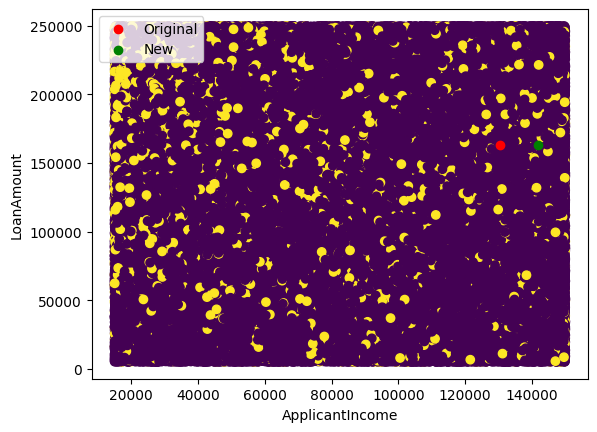

In [26]:
# Check for plausability
# minimal = sorted_b.iloc[0].to_numpy() if len(sorted_b) > 0 else None
data = pd.read_csv(filename)
income = data['Income']
loan = data['LoanAmount']
default = data['Default']
plt.scatter(income, loan, c=default, cmap='viridis')
# Unscale the minimal point
minimal_unscaled = unscale_instance(torch.tensor(sorted_b.iloc[0].to_numpy()), metadata) if len(sorted_b) > 0 else None
plt.scatter(a['Income'][0], a['LoanAmount'][0], c='red', label='Original')
plt.scatter(a['Income'][1], a['LoanAmount'][1], c='green', label='New')
plt.scatter(minimal_unscaled[1], minimal_unscaled[2], c='black', label='Minimal') if len(sorted_b) > 0 else None
plt.xlabel('ApplicantIncome')
plt.ylabel('LoanAmount')
plt.legend()
plt.show()

# Curvas de nivel y más graficos bonitos

### Calculo de derivadas explicitas del modelo

In [61]:
# derivative of the model_eq
model_eq_diff_x1 = model_eq.diff('x2')
model_eq_diff_x2 = model_eq.diff('x3')
print(model_eq_diff_x1)
print(model_eq_diff_x2)

0.871563*(-1.14736*(-0.47219*(-0.0686504552778534*exp(0.603065*x2 - 0.420633*x3)/(0.18672023781861*exp(0.603065*x2 - 0.420633*x3) + 1)**2 - 0.0344609640963304*exp(0.506093*x2 - 0.43031*x3)/(0.130793777772998*exp(0.506093*x2 - 0.43031*x3) + 1)**2 - 0.0336697372321946*exp(0.410075*x2 - 0.333227*x3)/(0.159123828844163*exp(0.410075*x2 - 0.333227*x3) + 1)**2 - 0.0295527061449081*exp(0.367078*x2 - 0.39095*x3)/(0.149384390603055*exp(0.367078*x2 - 0.39095*x3) + 1)**2 - 0.0267858137306137*exp(-0.332786*x2 + 0.335924*x3)/(exp(-0.332786*x2 + 0.335924*x3) + 0.210567146442257)**2 - 0.0232236306469333*exp(-0.395104*x2 + 0.519326*x3)/(exp(-0.395104*x2 + 0.519326*x3) + 0.141112704035184)**2 - 0.00923047147447004*exp(-0.395989*x2 + 0.341228*x3)/(exp(-0.395989*x2 + 0.341228*x3) + 0.189289887085242)**2 - 0.0152742373131678*exp(-0.400508*x2 + 0.289444*x3)/(exp(-0.400508*x2 + 0.289444*x3) + 0.132503343576189)**2 - 0.0151316378644379*exp(-0.420954*x2 + 0.472439*x3)/(exp(-0.420954*x2 + 0.472439*x3) + 0.13984

## Derivatives
### Derivatives with autograd

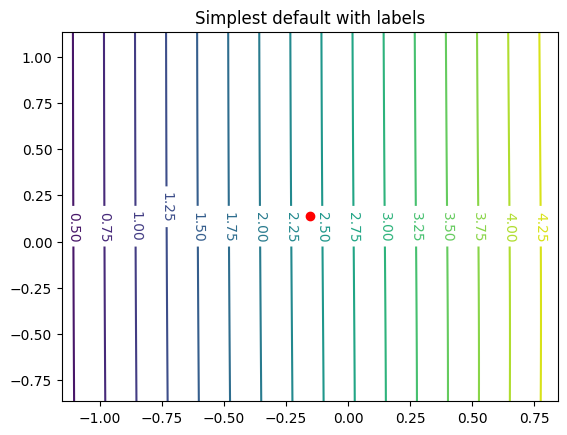

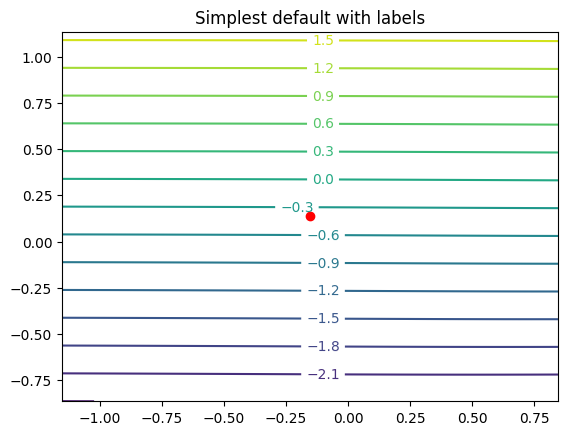

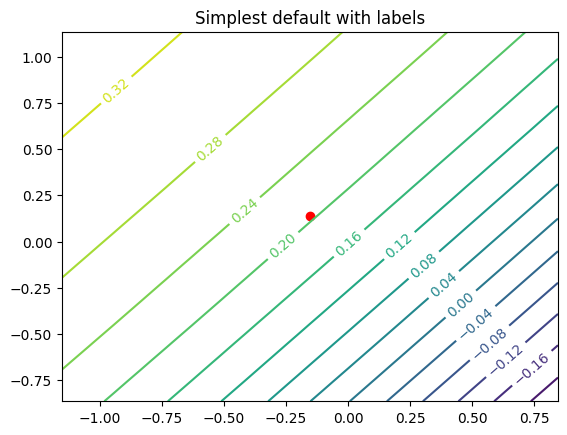

In [ ]:
# Draw contour plot
number = 5
person_n = inputs[number].clone().detach()
x = np.linspace(person_n[1] - 1, person_n[1] + 1, 20)
y = np.linspace(person_n[2] - 1, person_n[2] + 1, 20)
l_lin = np.linspace(-0.9, 1.1, 20)

X, Y = np.meshgrid(x, y)
d1 = np.zeros_like(X)
d2 = np.zeros_like(X)
dl = np.zeros_like(X)
for i in range(X.shape[0]):
    print(i, end='\r')
    for j in range(X.shape[1]):
        person_n = inputs[number].clone().detach()
        person_n[1] = torch.tensor(X[i, j], dtype=torch.float32)
        person_n[2] = torch.tensor(Y[i, j], dtype=torch.float32)
        person_n.requires_grad = True
        k = torch.nn.Parameter(torch.tensor(0.1, dtype=torch.float32).to(device))
        fpl = fpl_func(person_n, k)
        d1[i, j] = fpl[0].item()
        d2[i, j] = fpl[1].item()
        dl[i, j] = fpl[2].item()

# import matplotlib.pyplot as plt
# plt.contourf(X, Y, Z, levels=15)
# plt.scatter(person[1], person[2], c='red')
# plt.colorbar()
# Draw contour lines
person_n = inputs[number].clone().detach().numpy()
CS = plt.contour(X, Y, d1, levels=15) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(person_n[1], person_n[2], c='red')
plt.title('Simplest default with labels')
plt.show()
plt.figure()
CS = plt.contour(X, Y, d2, levels=15) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(person_n[1], person_n[2], c='red')
plt.title('Simplest default with labels')
plt.show()
plt.figure()
CS = plt.contour(X, Y, dl, levels=15) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(person_n[1], person_n[2], c='red')
plt.title('Simplest default with labels')
plt.show()


## Derivatives with explicit equations
esto es lo mismo que arriba y salen las mismas graficas pero tarda más

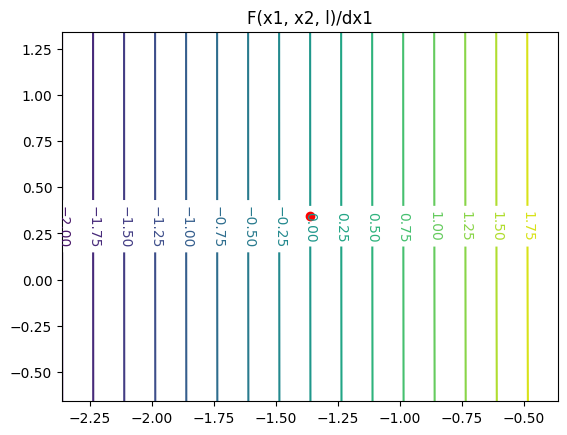

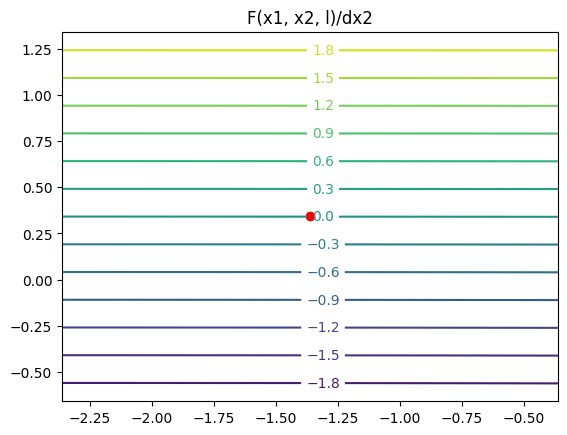

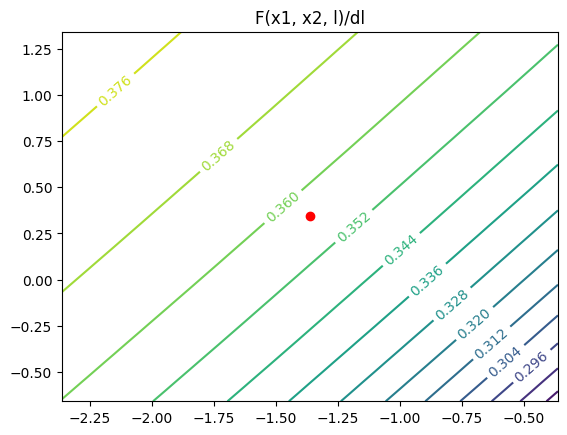

In [ ]:
# # Draw contour plot
# number = 4
# person_n = inputs[number].clone().detach()
# x = np.linspace(person_n[1] - 1, person_n[1] + 1, 20)
# y = np.linspace(person_n[2] - 1, person_n[2] + 1, 20)
# l_lin = np.linspace(-0.9, 1.1, 20)

# X, Y = np.meshgrid(x, y)
# d1 = np.zeros_like(X)
# d2 = np.zeros_like(X)
# dl = np.zeros_like(X)
# for i in range(X.shape[0]):
#     print(i, end='\r')
#     for j in range(X.shape[1]):
#         person_n = inputs[number].clone().detach()
#         person_n[1] = torch.tensor(X[i, j], dtype=torch.float32)
#         person_n[2] = torch.tensor(Y[i, j], dtype=torch.float32)
#         person_n.requires_grad = True
#         # k = torch.nn.Parameter(torch.tensor(1, dtype=torch.float32).to(device))
#         k = 0.1
#         d1[i, j] = (torch.autograd.grad(distance(inputs[number], person_n, weights), person_n, create_graph=True, allow_unused=True)[0][weights == 1][0] 
#                     - k * model_eq_diff_x1.subs({'x2': X[i, j], 'x3': Y[i, j]}))
#         d2[i, j] = (torch.autograd.grad(distance(inputs[number], person_n, weights), person_n, create_graph=True, allow_unused=True)[0][weights == 1][1] 
#                     - k * model_eq_diff_x2.subs({'x2': X[i, j], 'x3': Y[i, j]}))
#         dl[i, j] = (0.5 - model_eq.subs({'x2': X[i, j], 'x3': Y[i, j]}))
            
# # import matplotlib.pyplot as plt
# # plt.contourf(X, Y, Z, levels=15)
# # plt.scatter(person[1], person[2], c='red')
# # plt.colorbar()
# # Draw contour lines

# person_n = inputs[number].clone().detach().numpy()
# CS = plt.contour(X, Y, d1, levels=15) # CS is the ContourSet
# plt.clabel(CS, inline=1, fontsize=10)
# plt.scatter(person_n[1], person_n[2], c='red')
# plt.title('F(x1, x2, l)/dx1')
# plt.show()
# plt.figure()
# CS = plt.contour(X, Y, d2, levels=15) # CS is the ContourSet
# plt.clabel(CS, inline=1, fontsize=10)
# plt.scatter(person_n[1], person_n[2], c='red')
# plt.title('F(x1, x2, l)/dx2')
# plt.show()
# plt.figure()
# CS = plt.contour(X, Y, dl, levels=15) # CS is the ContourSet
# plt.clabel(CS, inline=1, fontsize=10)
# plt.scatter(person_n[1], person_n[2], c='red')
# plt.title('F(x1, x2, l)/dl')
# plt.show()


## Delta

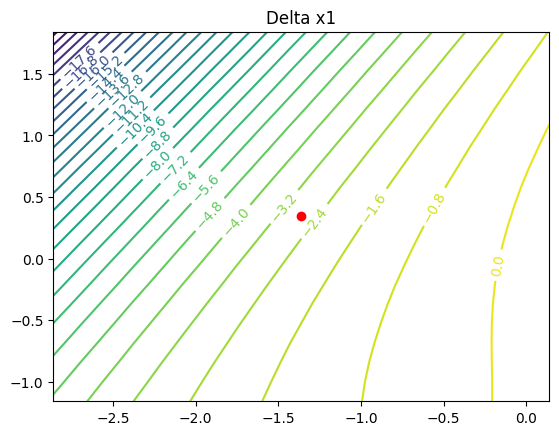

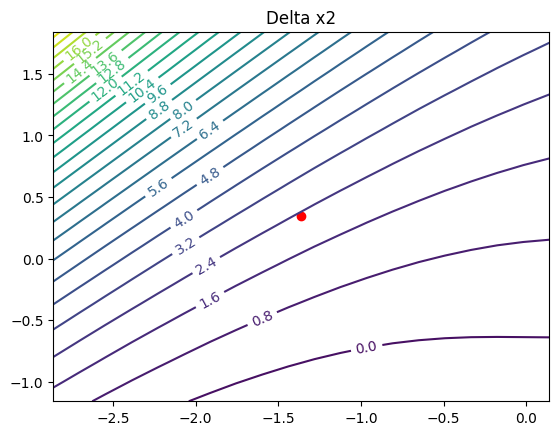

In [98]:
# Draw contour plot
number = 4
person_n = inputs[number].clone().detach()
x = np.linspace(person_n[1] - 1.5, person_n[1] + 1.5, 20)
y = np.linspace(person_n[2] - 1.5, person_n[2] + 1.5, 20)
l_lin = np.linspace(-0.9, 1.1, 20)

X, Y = np.meshgrid(x, y)
d1 = np.zeros_like(X)
d2 = np.zeros_like(X)
dl = np.zeros_like(X)
for i in range(X.shape[0]):
    print(i, end='\r')
    for j in range(X.shape[1]):
        # for k in range(l_lin.shape[0]):
        person_n = inputs[number].clone().detach()
        person_n[1] = torch.tensor(X[i, j], dtype=torch.float32)
        person_n[2] = torch.tensor(Y[i, j], dtype=torch.float32)
        person_n.requires_grad = True
        l = torch.nn.Parameter(torch.tensor(0.1, dtype=torch.float32).to(device))
        fpl = fpl_func(person_n, l)
        jac_tuple = torch.autograd.functional.jacobian(fpl_func, (person_n, l))

        # delta_full, delta_l = newton_step_masked(loss_value, person_new, l, weights, True)
        jac = torch.cat((jac_tuple[0][:, weights == 1], jac_tuple[1].unsqueeze(-1)), dim=1)
        delta = (torch.tensor(np.linalg.inv(jac))) @ fpl
        # get determinant
        d1[i, j] = delta[0].item()
        d2[i, j] = delta[1].item()
        dl[i, j] = delta[2].item()
                
person_n = inputs[number].clone().detach().numpy()
plt.figure()
CS = plt.contour(X, Y, d1, levels=30) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(person_n[1], person_n[2], c='red')
plt.title('Delta x1')
plt.show()
plt.figure()
CS = plt.contour(X, Y, d2, levels=30) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(person_n[1], person_n[2], c='red')
plt.title('Delta x2')
plt.show()

## Comprobar l.i de las filas de la hessiana

In [68]:
# Draw contour plot
number = 0
person_n = inputs_useful[number].clone().detach()
x = np.linspace(person_n[1] - 5, person_n[1] + 5, 20)
y = np.linspace(person_n[2] - 5, person_n[2] + 5, 20)
l_lin = np.linspace(0.1 - 5, 0.1 + 5, 20)

X, Y = np.meshgrid(x, y)
d1 = np.zeros_like(X)
d2 = np.zeros_like(X)
dl = np.zeros_like(X)
for i in range(X.shape[0]):
    print(i, end='\r')
    for j in range(X.shape[1]):
        # for k in range(l_lin.shape[0]):
        person_n = inputs_useful[number].clone().detach()
        person_n[1] = torch.tensor(X[i, j], dtype=torch.float32)
        person_n[2] = torch.tensor(Y[i, j], dtype=torch.float32)
        person_n.requires_grad = True
        l = torch.nn.Parameter(torch.tensor(0.1, dtype=torch.float32).to(device))
        fpl = fpl_func(person_n, l)
        jac_tuple = torch.autograd.functional.jacobian(fpl_func, (person_n, l))

        # delta_full, delta_l = newton_step_masked(loss_value, person_new, l, weights, True)
        jac = torch.cat((jac_tuple[0][:, weights == 1], jac_tuple[1].unsqueeze(-1)), dim=1)
        # get rank of jac
        det = torch.linalg.det(jac)
        # print(det) if det <= 0.01 else None
        # get determinant
        d1[i, j] = det.item()

            # d2[i, j] = delta[1].item()
            # dl[i, j] = delta[2].item()
                


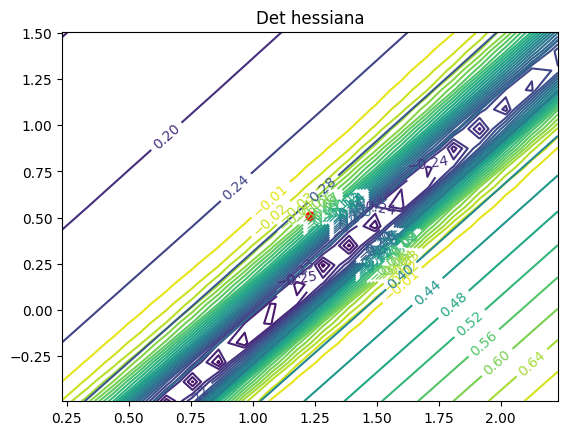

In [71]:
person_n = inputs_useful[number].clone().detach().numpy()
plt.figure()
CS = plt.contour(X, Y, d1, levels=30) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(person_n[1], person_n[2], c='red')
CS = plt.contour(X, Y, Z, levels=15) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(inputs_useful[0][1].item(), inputs_useful[0][2].item(), c='red')

# plt.scatter(track_person[0][metadata.good_class], track_person[0][1], c='green')
# plt.scatter(track_person[1][0], track_person[1][1], c='green')
# plt.scatter(track_person[2][0], track_person[2][1], c='green')
plt.title('Det hessiana')
plt.show()
# plt.figure()
# CS = plt.contour(X, Y, d2, levels=30) # CS is the ContourSet
# plt.clabel(CS, inline=1, fontsize=10)
# plt.scatter(person_n[1], person_n[2], c='red')
# plt.title('Delta x2')
# plt.show()

In [78]:
x = np.linspace(inputs_useful[4][1].item() - 1, inputs_useful[4][1].item() + 1, 20)
y = np.linspace(inputs_useful[4][2].item() - 1, inputs_useful[4][2].item() + 1, 20)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
dist_Z = np.zeros_like(X)

for i in range(X.shape[0]):
    print(i, end='\r')
    for j in range(X.shape[1]):
        # Z[i, j] = float(symbolic_eq.subs({sp.symbols('x2'): X[i, j], sp.symbols('x3'): Y[i, j]})[0])
        p = inputs_useful[4].clone().detach()
        p[1] = torch.tensor(X[i, j], dtype=torch.float32)
        p[2] = torch.tensor(Y[i, j], dtype=torch.float32)
        Z[i, j] = model(p.unsqueeze(0))[0][metadata.good_class].item()

        # temp_inputs = inputs[0].clone()
        # temp_inputs[1] = X[i, j]
        # temp_inputs[2] = Y[i, j]
        # dist_Z[i, j] = distance(inputs[0], temp_inputs, weights)



In [58]:
inputs_useful[4][1:3]

tensor([-1.3904, -0.3218], dtype=torch.float32)

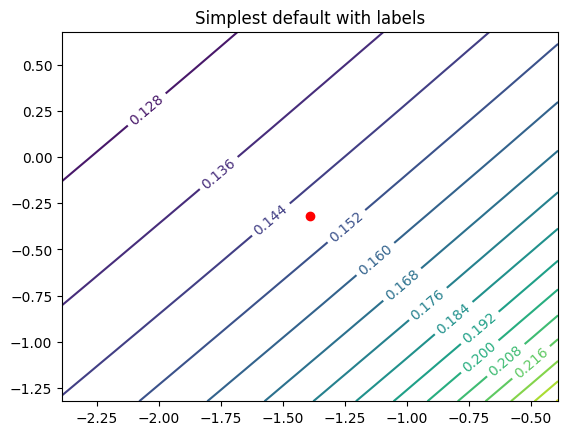

In [79]:
plt.show()
plt.figure()
CS = plt.contour(X, Y, Z, levels=15) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(inputs_useful[4][1].item(), inputs_useful[4][2].item(), c='red')
plt.title('Simplest default with labels')
plt.show()


## Determinante de la hessiana

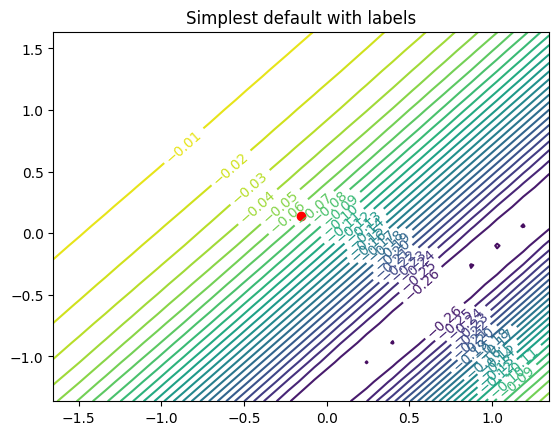

In [ ]:
# Draw contour plot
number = 5
person_n = inputs[number].clone().detach()
x = np.linspace(person_n[1] - 1.5, person_n[1] + 1.5, 20)
y = np.linspace(person_n[2] - 1.5, person_n[2] + 1.5, 20)
l_lin = np.linspace(-0.9, 1.1, 20)

X, Y = np.meshgrid(x, y)
d1 = np.zeros_like(X)
d2 = np.zeros_like(X)
dl = np.zeros_like(X)
for i in range(X.shape[0]):
    print(i, end='\r')
    for j in range(X.shape[1]):
        # for k in range(l_lin.shape[0]):
        person_n = inputs[number].clone().detach()
        person_n[1] = torch.tensor(X[i, j], dtype=torch.float32)
        person_n[2] = torch.tensor(Y[i, j], dtype=torch.float32)
        person_n.requires_grad = True
        l = torch.nn.Parameter(torch.tensor(0.1, dtype=torch.float32).to(device))
        fpl = fpl_func(person_n, l)
        jac_tuple = torch.autograd.functional.jacobian(fpl_func, (person_n, l))

        # delta_full, delta_l = newton_step_masked(loss_value, person_new, l, weights, True)
        jac = torch.cat((jac_tuple[0][:, weights == 1], jac_tuple[1].unsqueeze(-1)), dim=1)
        # get determinant
        d1[i, j] = torch.det(jac)
                
person_n = inputs[number].clone().detach().numpy()
CS = plt.contour(X, Y, d1, levels=30) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(person_n[1], person_n[2], c='red')
plt.title('Determinante de la hessiana')
plt.show()

## Hessian (1,0) and (0,1)

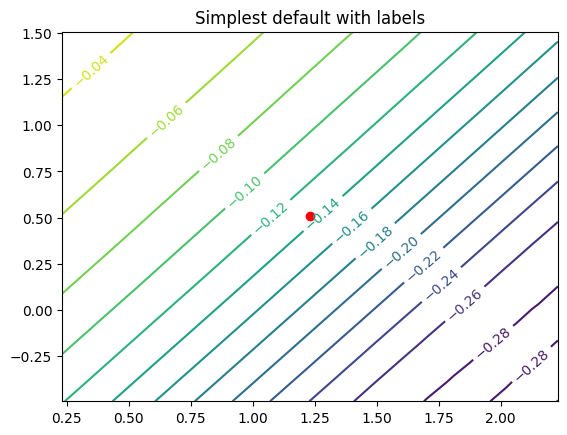

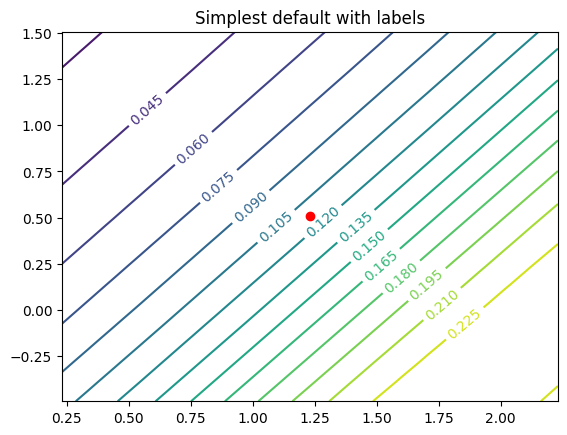

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [91]:
# Draw contour plot
number = 0
person_n = inputs[number].clone().detach()
x = np.linspace(person_n[1] - 1, person_n[1] + 1, 20)
y = np.linspace(person_n[2] - 1, person_n[2] + 1, 20)

X, Y = np.meshgrid(x, y)
d1l = np.zeros_like(X)
d2l = np.zeros_like(X)
for i in range(X.shape[0]):
    print(i, end='\r')
    for j in range(X.shape[1]):
        d1l[i, j] = - model_eq_diff_x1.subs({'x2': X[i, j], 'x3': Y[i, j]})
        d2l[i, j] = - model_eq_diff_x2.subs({'x2': X[i, j], 'x3': Y[i, j]})
            
# import matplotlib.pyplot as plt
# plt.contourf(X, Y, Z, levels=15)
# plt.scatter(person[1], person[2], c='red')
# plt.colorbar()
# Draw contour lines
person_n = inputs[number].clone().detach().numpy()
CS = plt.contour(X, Y, d1l, levels=15) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(person_n[1], person_n[2], c='red')
plt.title('Simplest default with labels')
plt.show()
plt.figure()
CS = plt.contour(X, Y, d2l, levels=15) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(person_n[1], person_n[2], c='red')
plt.title('Simplest default with labels')
plt.show()
plt.figure()


### Punto inicial

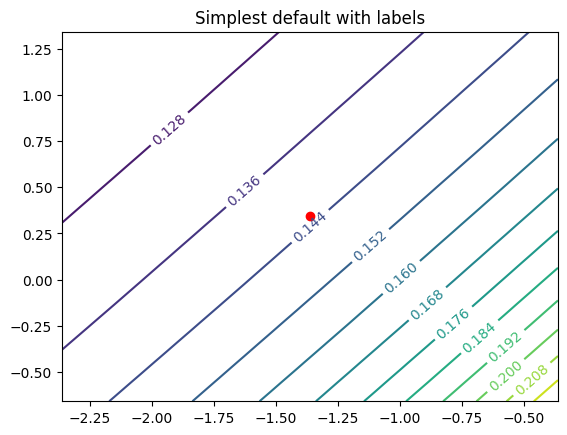

In [72]:
# Draw contour plot
x = np.linspace(inputs[4][1] - 1, inputs[4][1] + 1, 20)
y = np.linspace(inputs[4][2] - 1, inputs[4][2] + 1, 20)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
dist_Z = np.zeros_like(X)

for i in range(X.shape[0]):
    print(i, end='\r')
    for j in range(X.shape[1]):
        Z[i, j] = float(symbolic_eq.subs({sp.symbols('x2'): X[i, j], sp.symbols('x3'): Y[i, j]})[0])
        temp_inputs = inputs[4].clone()
        temp_inputs[1] = X[i, j]
        temp_inputs[2] = Y[i, j]
        dist_Z[i, j] = distance(inputs[4], temp_inputs, weights)


# import matplotlib.pyplot as plt
# plt.contourf(X, Y, Z, levels=15)
# plt.scatter(inputs[4][1], inputs[4][2], c='red')
# plt.colorbar()
# Draw contour lines

plt.show()
plt.figure()
CS = plt.contour(X, Y, Z, levels=15) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(inputs[4][1], inputs[4][2], c='red')
plt.title('Simplest default with labels')
plt.show()


### Pintando alrededor del punto final

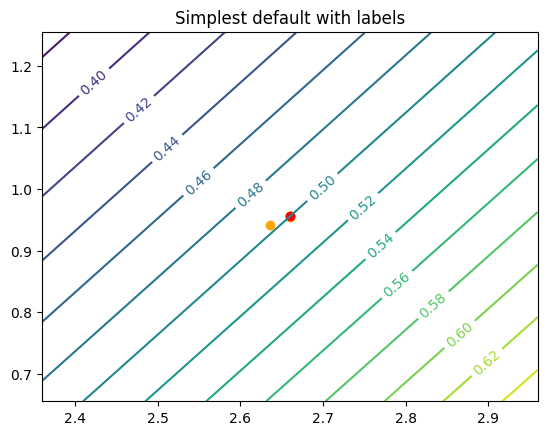

In [ ]:
# Draw contour plot
import numpy as np



x = np.linspace(track_person[-1][0] - 0.3, track_person[-1][0] + 0.3, 20)
y = np.linspace(track_person[-1][1] - 0.3, track_person[-1][1] + 0.3, 20)

X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)
dist_Z = np.zeros_like(X)

for i in range(X.shape[0]):
    print(i, end='\r')
    for j in range(X.shape[1]):
        Z[i, j] = float(symbolic_eq.subs({sp.symbols('x2'): X[i, j], sp.symbols('x3'): Y[i, j]})[0])
        temp_inputs = inputs[0].clone()
        temp_inputs[1] = X[i, j]
        temp_inputs[2] = Y[i, j]
        dist_Z[i, j] = distance(inputs[0], temp_inputs, weights)


# import matplotlib.pyplot as plt
# plt.contourf(X, Y, Z, levels=15)
# plt.scatter(person_new[1].item(), person_new[2].item(), c='red')
# plt.colorbar()
# Draw contour lines

plt.show()
plt.figure()
CS = plt.contour(X, Y, Z, levels=15) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter([x[0] for x in track_person], [x[1] for x in track_person], c='orange')
plt.scatter(track_person[-1][0], track_person[-1][1], c='red')
plt.title('Simplest default with labels')
plt.show()


In [ ]:
# # Draw contour plot
# import numpy as np



# x = np.linspace(person_new[1].item() - 0.07, person_new[1].item() + 0.07, 20)
# y = np.linspace(person_new[2].item() - 0.07, person_new[2].item() + 0.07, 20)

# X, Y = np.meshgrid(x, y)
# Z = np.zeros_like(X)
# dist_Z = np.zeros_like(X)

# for i in range(X.shape[0]):
#     print(i, end='\r')
#     for j in range(X.shape[1]):
#         Z[i, j] = float(symbolic_eq.subs({sp.symbols('x2'): X[i, j], sp.symbols('x3'): Y[i, j]})[0])
#         temp_inputs = inputs[0].clone()
#         temp_inputs[1] = X[i, j]
#         temp_inputs[2] = Y[i, j]
#         dist_Z[i, j] = distance(inputs[0], temp_inputs, weights)


# # import matplotlib.pyplot as plt
# # plt.contourf(X, Y, Z, levels=15)
# # plt.scatter(person_new[1].item(), person_new[2].item(), c='red')
# # plt.colorbar()
# # Draw contour lines

# plt.show()
# plt.figure()
# CS = plt.contour(X, Y, Z, levels=15) # CS is the ContourSet
# plt.clabel(CS, inline=1, fontsize=10)
# plt.scatter(person_new[1].item(), person_new[2].item(), c='red')
# plt.title('Simplest default with labels')
# plt.show()


KeyboardInterrupt: 

### gradient as an arrow

In [ ]:
# plt.figure()
# CS = plt.contour(X, Y, Z, levels=15) # CS is the ContourSet
# plt.clabel(CS, inline=1, fontsize=10)
# # Draw the gradient of the point as an arrow
# grad = person_new.grad
# plt.arrow(person_new[1].item(), person_new[2].item(), grad[1].item(), grad[2].item(), head_width=0.005, head_length=0.01, fc='r', ec='r')
# plt.scatter(person_new[1].item(), person_new[2].item(), c='red')
# plt.title('Simplest default with labels')
# plt.show()

Text(0.5, 1.0, 'Simplest default with labels')

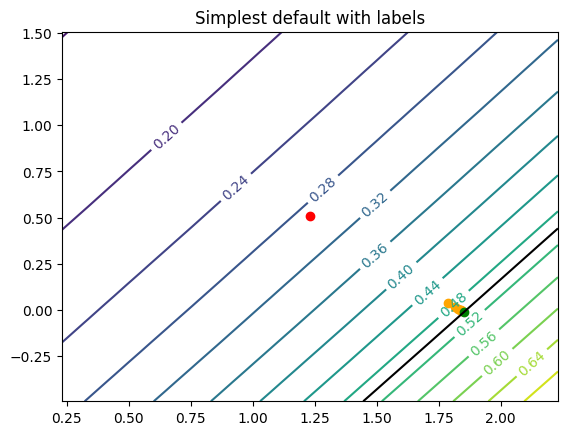

In [ ]:
plt.figure()
CS = plt.contour(X, Y, Z, levels=15) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
# Paint the 0.5 threshold
plt.contour(X, Y, Z, levels=[0.5], colors='black')
plt.scatter(inputs[0][1], inputs[0][2], c='red')
plt.scatter([x[0] for x in track_person], [x[1] for x in track_person], c='orange')
plt.scatter(person_new[1].item(), person_new[2].item(), c='green')
plt.title('Simplest default with labels')

Text(0.5, 1.0, 'Simplest default with labels')

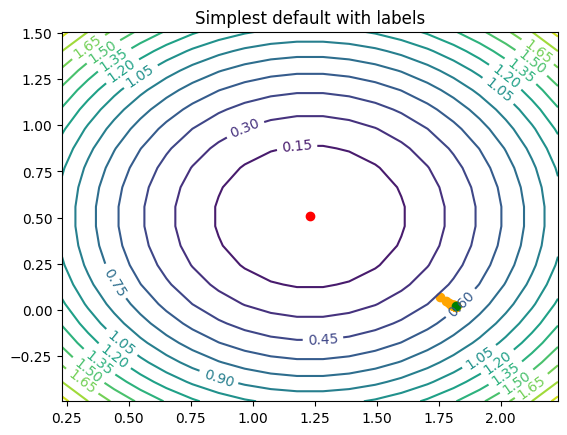

In [ ]:
plt.figure()
CS = plt.contour(X, Y, dist_Z, levels=15) # CS is the ContourSet
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(inputs[0][1], inputs[0][2], c='red')
plt.scatter([x[0] for x in track_person], [x[1] for x in track_person], c='orange')
plt.scatter(person_new[1].item(), person_new[2].item(), c='green')
plt.title('Simplest default with labels')

In [ ]:
track_person

[(1.3406583115399153, -1.9546033612111067),
 (-6.470774114293334, 4.725250527266087),
 (430.64144550311937, -370.7041668324924)]

Text(0.5, 1.0, 'Simplest default with labels')

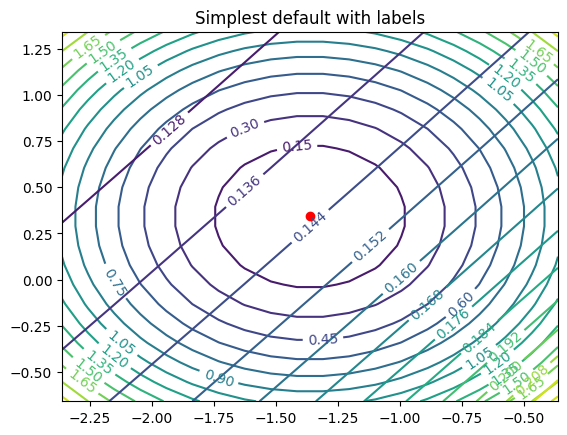

In [ ]:
plt.figure()
dist_CS = plt.contour(X, Y, dist_Z, levels=15) # CS is the ContourSet
CS = plt.contour(X, Y, Z, levels=15) # CS is the ContourSet
plt.clabel(dist_CS, inline=1, fontsize=10)
plt.clabel(CS, inline=1, fontsize=10)
plt.scatter(inputs[4][1], inputs[4][2], c='red')
# plt.scatter(track_person[1][0], track_person[1][1], c='orange')
# plt.scatter([x[0] for x in track_person], [x[1] for x in track_person], c='orange')
# plt.scatter(person_new[1].item(), person_new[2].item(), c='green')
plt.title('Simplest default with labels')